In [1]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(123)

In [3]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
# Splitting data into training/testing
from sklearn.model_selection import train_test_split

## 1. Simple Linear Regression

### Load the data


In [4]:
datafolder = "/content/drive/My Drive/NUS/BT4012/"
file_name = "student-mat.csv"
df_data = pd.read_csv(datafolder + file_name, sep=';', index_col=None)

In [5]:
df_data.rename(columns={'G3': 'Grade'}, inplace=True)
df_data = df_data[~df_data['Grade'].isin([0, 1])]
df_used = df_data[['studytime', 'Medu', 'Grade']]

In [6]:
df_used.head(2)

,studytime,Medu,Grade
0,2,4,6
1,2,1,6


In [7]:
df_X = df_used[['studytime', 'Medu']] #store features
df_y = df_used[['Grade']]

In [8]:
 # Split into training/testing sets with 25% split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size = 0.25,
                                                    random_state=123)

### *Train linear regression model on X_train and y_train*

* Adopt the default hyperparamter setting 


In [9]:
## write your code
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### *Check MAE and RMSE on testing data*

In [10]:
## Write your code 
predictions = lr.predict(X_test)
mae = np.mean(abs(predictions - y_test))
rmse = np.sqrt(np.mean((predictions - y_test)**2))
print('MAE: %0.2f' %  mae)  
print('RMSE: %0.2f' %  rmse)    

MAE: 2.84
RMSE: 3.45


### *Check the predicted grade of one student*

The 10th student in the testing data

In [11]:
## write your code
predictions[9]

array([11.99194585])

### *Print the learned model parameters of linear regression*


In [12]:
## Write your code
intercept = lr.intercept_[0]
coef = lr.coef_
formula = 'Grade = %0.2f +' % intercept

for i, col in enumerate(X_train.columns):
    formula += ' %0.2f * %s +' % (coef[0][i], col)
    
print(formula[:-2])
print()
print("For an unit increase in study time, expected grade increases by 0.68, independent of all other variables.\
 Likewise, for an unit increase in Medu, expected grade increases by 0.47, independent of all other variables.")

Grade = 8.75 + 0.68 * studytime + 0.47 * Medu

For an unit increase in study time, expected grade increases by 0.68, independent of all other variables. Likewise, for an unit increase in Medu, expected grade increases by 0.47, independent of all other variables.


## 2. Bayesian Linear Regression

Here, two bayesian models will be implemented with **two different sets of prior functions**. The first bayeisan model is given as:

$u_i = \beta_0 + \beta_1*{studytime}_i + \beta_2*{medu}_i$

$grade_i \sim Norm(u_i, \sigma^2_\epsilon)$

$\beta_0 \sim Norm(0, 1)$

$\beta_1 \sim Norm(0, 1)$

$\beta_2 \sim Norm(0, 100)$

$\sigma_\epsilon \sim {Uniform}(0, 10)$

Here, $\beta_0$ is the intercept. Then, $\beta_1$ and $\beta_2$ are the coefficients for features: studytime and medu.  For the i-th datasample, a mean $u_i$ can be computed linearly from two features. Then, the target grade $y_i$ is assumed to be normally distributed around this $u_i$.

##### Make sure the version of pymc3 is 3.8

In [13]:
! pip install pymc3==3.8

     |████████████████████████████████| 911kB 2.7MB/s 
     |████████████████████████████████| 1.5MB 16.3MB/s 
     |████████████████████████████████| 4.3MB 23.7MB/s 
     |████████████████████████████████| 296kB 44.3MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [14]:
import pymc3 as pm

In [15]:
## Define your model here
def model_build(df_train, df_label=None):
    """
    build genearlized linear model
    """
    with pm.Model() as model:
        ## write your code here
        num_fea = df_train.shape[1]
        
        #error term
        sigma = pm.Uniform('sigma', 0, 10)
        
        #intercept
        mu_infe = pm.Normal('intercept', mu=0, sigma=1) 
        
        #beta1
        mu_infe = mu_infe + pm.Normal('beta_1_coeff_for_{}'.format(df_train.columns[0]), mu=0, sigma=1)*df_train.loc[:, df_train.columns[0]]
        
        #beta2
        mu_infe = mu_infe + pm.Normal('beta_2_coeff_for_{}'.format(df_train.columns[1]), mu=0, sigma=10)*df_train.loc[:, df_train.columns[1]]

        if df_label is None:
          # inference
          likelihood = pm.Normal('y', mu=mu_infe, sigma=sigma, observed = False)
        else:
          # training
          likelihood = pm.Normal('y', mu=mu_infe, sigma=sigma, observed = df_label['Grade'].values)
        return model

In [16]:
# Use MCMC algorithm to draw samples to approximate the posterior for model parameters (error term, bias term and all coefficients)
with model_build(X_train, y_train):
    trace = pm.sample(draws=2000, chains = 2, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_2_coeff_for_Medu, beta_1_coeff_for_studytime, intercept, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:06<00:00, 409.96it/s]


In [17]:
# sample the posterior predictive distribution for the 10th student in testing data
# 4000 samples (2 chains and each chain has 2000 samples) will be sampled for this student.
with model_build(X_test.iloc[9:10,:]):
    ppc = pm.sample_posterior_predictive(trace)

100%|██████████| 4000/4000 [00:07<00:00, 521.53it/s]


*Compute the mean and standard deviation of your prediction.*

In [18]:
## write your code
print("The mean of prediction is %0.3f and the standard deviation is %0.3f " %(np.mean(ppc['y']),np.std(ppc['y'])))

The mean of prediction is 12.353 and the standard deviation is 3.163 


### *Check the posterior distribution for the model parameters*

$p(w|D)$

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                             mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
intercept                   6.054  0.589   4.977  ...    2091.0    2100.0    1.0
beta_1_coeff_for_studytime  1.187  0.208   0.797  ...    2487.0    1841.0    1.0
beta_2_coeff_for_Medu       0.988  0.176   0.672  ...    2223.0    1977.0    1.0
sigma                       3.168  0.148   2.907  ...    2536.0    1820.0    1.0

[4 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8ead4d7f0>,
      dtype=object)

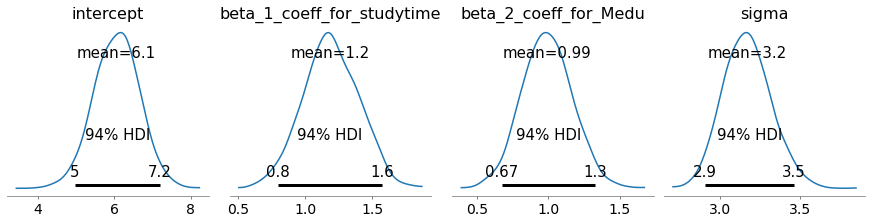

In [19]:
## write your code here
print(pm.summary(trace).round(5))

pm.plot_posterior(trace, figsize = (12, 3))

The other bayeisan model is given as:

$u_i = \beta_0 + \beta_1*{studytime}_i + \beta_2*{medu}_i$

$grade_i \sim Norm(u_i, \sigma^2_\epsilon)$

$\beta_0 \sim Norm(0, 100)$

$\beta_1 \sim Norm(0, 100)$

$\beta_2 \sim Norm(0, 100)$

$\sigma_\epsilon \sim {Uniform}(0, 10)$

In [20]:
## Define your model here
def model_build(df_train, df_label=None):
    """
    build genearlized linear model
    """
    with pm.Model() as model:
        ## write your code here
        num_fea = df_train.shape[1]
        
        #error term
        sigma = pm.Uniform('sigma', 0, 10)
        
        #intercept
        mu_infe = pm.Normal('intercept', mu=0, sigma=10) 
        
        #beta1
        mu_infe = mu_infe + pm.Normal('beta_1_coeff_for_{}'.format(df_train.columns[0]), mu=0, sigma=10)*df_train.loc[:, df_train.columns[0]]
        
        #beta2
        mu_infe = mu_infe + pm.Normal('beta_2_coeff_for_{}'.format(df_train.columns[1]), mu=0, sigma=10)*df_train.loc[:, df_train.columns[1]]

        if df_label is None:
          # inference
          likelihood = pm.Normal('y', mu=mu_infe, sigma=sigma, observed = False)
        else:
          # training
          likelihood = pm.Normal('y', mu=mu_infe, sigma=sigma, observed = df_label['Grade'].values)
        return model

In [21]:
# Use MCMC algorithm to draw samples to approximate the posterior for model parameters (error term, bias term and all coefficients)
with model_build(X_train, y_train):
    trace = pm.sample(draws=2000, chains = 2, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_2_coeff_for_Medu, beta_1_coeff_for_studytime, intercept, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:06<00:00, 394.84it/s]
The acceptance probability does not match the target. It is 0.881162011783612, but should be close to 0.8. Try to increase the number of tuning steps.


### *Similar to the first bayesian linear regression model, check the distribution for model parameters and the prediction distribution of the previous chosen data sample*

100%|██████████| 4000/4000 [00:05<00:00, 688.23it/s]
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


The mean of prediction is 11.989 and the standard deviation is 3.115 
                             mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
intercept                   8.739  0.640   7.496  ...    2542.0    2350.0    1.0
beta_1_coeff_for_studytime  0.687  0.224   0.274  ...    2916.0    2185.0    1.0
beta_2_coeff_for_Medu       0.470  0.171   0.156  ...    2995.0    2413.0    1.0
sigma                       3.073  0.136   2.826  ...    2787.0    2213.0    1.0

[4 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8e62e0b70>,
      dtype=object)

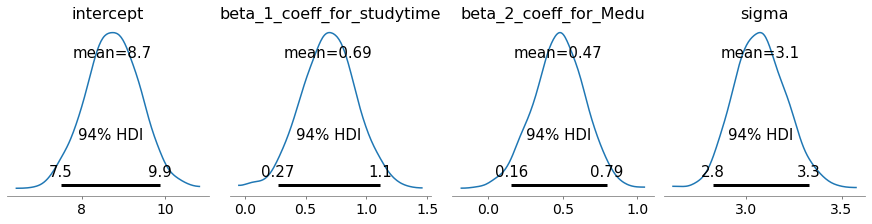

In [22]:
## write your code

# prediction distribution
with model_build(X_test.iloc[9:10,:]): # 9th student
    ppc = pm.sample_posterior_predictive(trace)

print("The mean of prediction is %0.3f and the standard deviation is %0.3f " %(np.mean(ppc['y']),np.std(ppc['y'])))

# distribution of model parameters
print(pm.summary(trace).round(5))

pm.plot_posterior(trace, figsize = (12, 3))

## 3. Compare Bayesian Linear Regression and Linear Regression (Frequentist)

**Frequentist**: Frequentist model provides a point estimate. This means that the model parameters and the predictions only have one fixed value.

**Bayesian**: Bayesian model treats each model parameter as a random variable following a distribution. This means that the model parameter and prediction is not fixed and has a mean and standard deviation.

**Differences**: Bayesian model allows us to show our uncertainty in the model by providing a distribution of our model parameters and predictions. How this uncertainty is shown is that instead of providing one single prediction (Frequentist) for the 10th student, we provide multiple estimations (in our case, we provided 4000 estimations with our Bayesian model). This is especially useful if we have very little data and we are unsure about the performance of our model. On the other hand, our frequentist model, may not be accurate and provide us with an inaccurate prediction for the 10th student, but this is not reflected as we only provided a fixed parameter and prediction.

The specified prior distribution allows us to feed our prior knowledge about the parameters to the model that we are trying to learn. Coupled with the actual data, bayesian learning then allows us to form a better estimate of the model parameters. It also increases our interpretability of the parameters and prediction as we are now able to display our uncertainty in the form of a distribution, instead of just a single value.

For instance, with the 3 models created above, we have:
1. Model 1: A simple linear regression
2. Model 2: A bayesian model with sigma = 1
3. Model 3: A bayesian model with sigma = 10

Comparing these 3 models, model 1 and model 3 provides very similar estimates whereas model 2 provides a different estimated score of 10th student and a different estimation of beta1 and beta2.

When the sigma is higher, we are showing that we are very uncertain of the model parameters. We are letting the data, instead of our prior knowledge of the model parameters tell the story. Hence, Model 3 should be very similar to model 1, where we are very uncertain of the model parameter. Hence, these 2 models should provide the same estimates.

On the other hand, if we were to use a small sigma (model 2), we have a narrow gaussian distribution, which implies that we are very certain that our model parameters should fall between these values. Hence, our estimations should vary differently from model 1(simple linear regression) as we are injecting our prior knowledge of model parameters into the model.